In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from time import time
import cvxpy as cp

## Testing Approximate Reference

In [2]:
n = 200
p = 5

np.random.seed(10001)
X = np.random.normal(size=(n, p))
a = 1
b = 2

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 2
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(max_depth=3, min_proportion=0,
                          min_samples_split=50, min_bucket=20,)

In [3]:
reg_tree.fit(X, y, sd = noise_sd * sd)

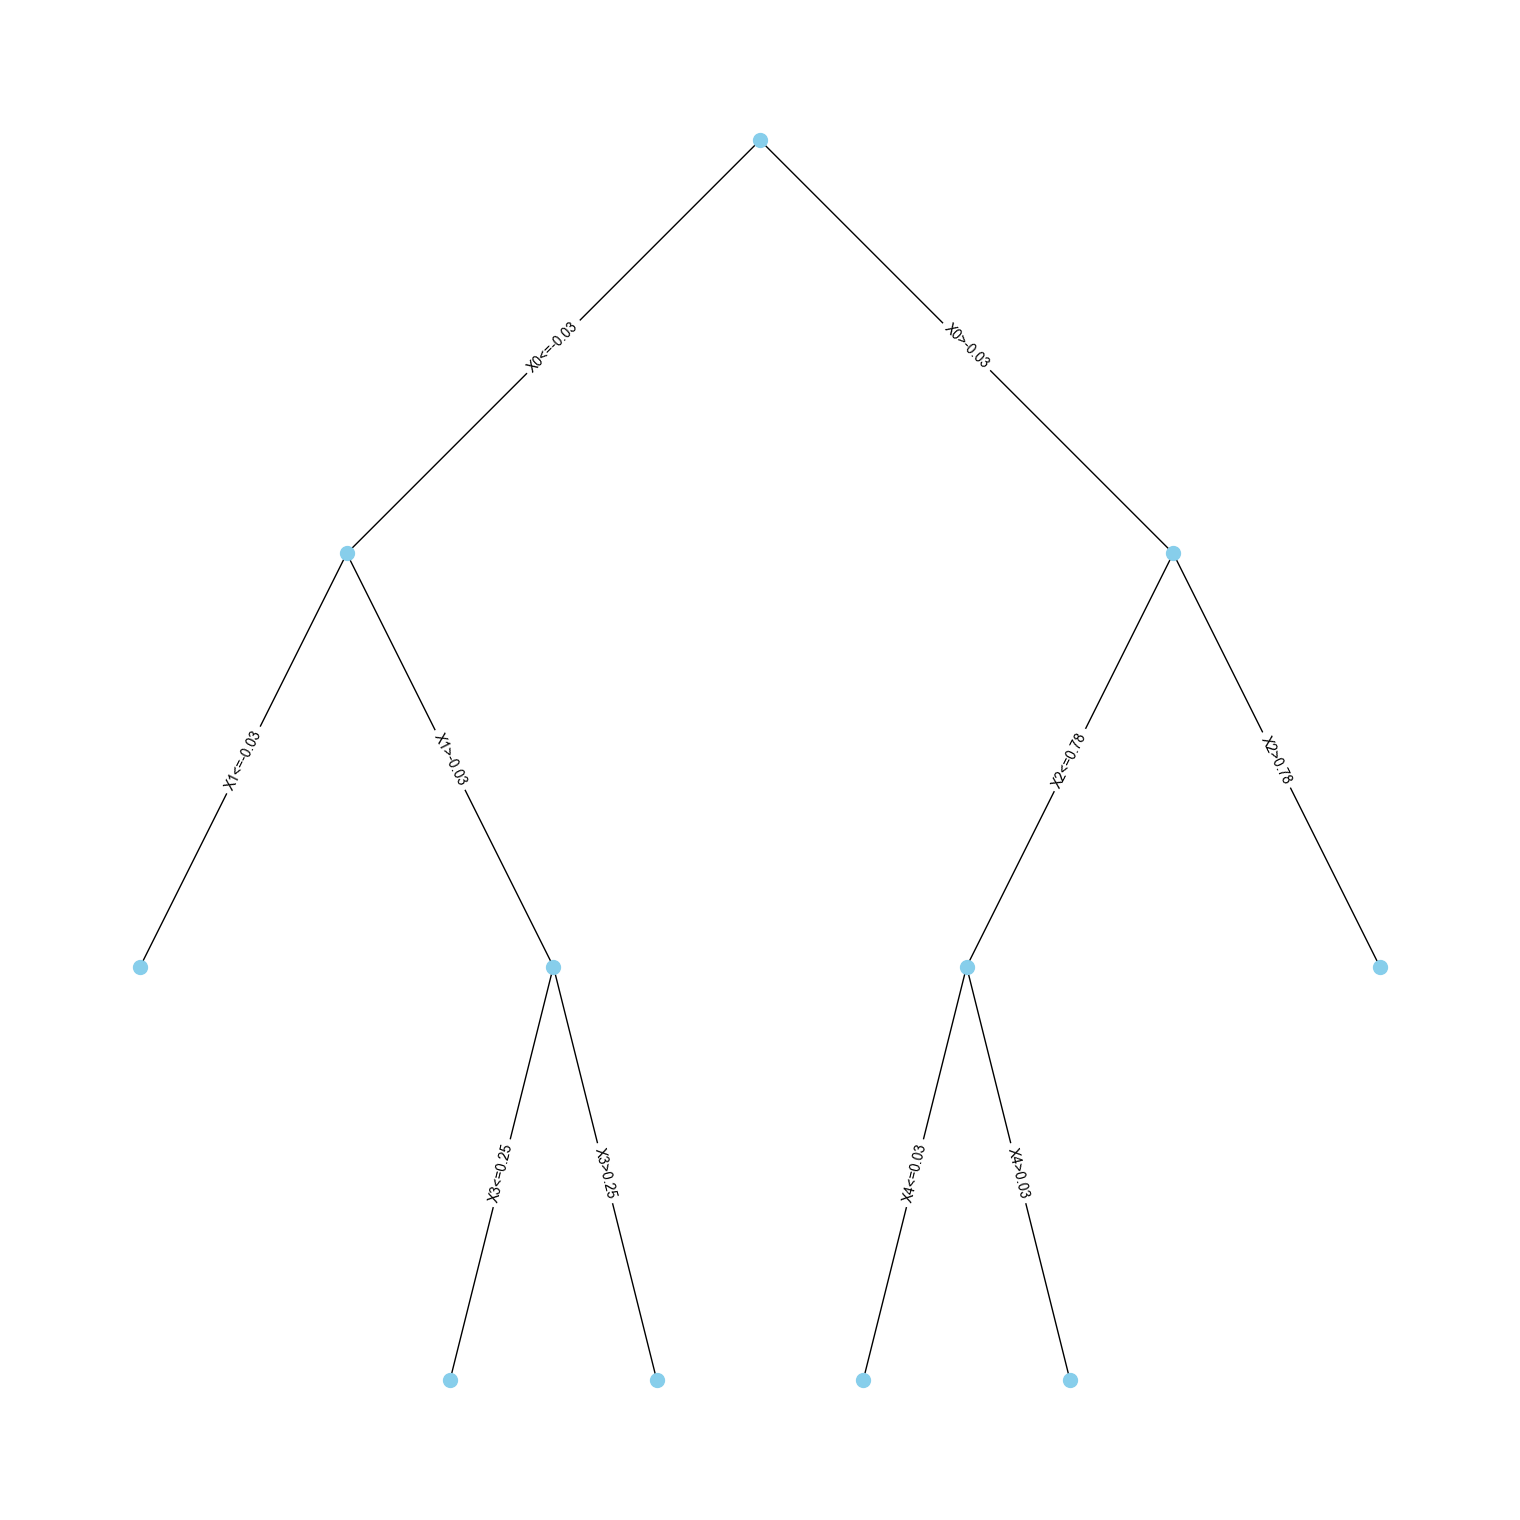

In [4]:
draw_tree(reg_tree.root)

In [5]:
t1 = time()
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, marginal = (
    reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[5], 
                                  ngrid=10000,
                                  ncoarse=50,
                                  grid_w_const=10,
                                  reduced_dim=None,
                                  sd=sd, use_cvxpy=True))
t2 = time()
print(t2 - t1)

12.117746829986572


In [6]:
t1 = time()
pval_full, dist_full, contrast_full, norm_contrast_full, obs_tar_full, logW_full, suff_full, sel_probs_full = (
    reg_tree.node_inference(node=reg_tree.terminal_nodes[5], 
                            ngrid=10000,
                            ncoarse=50,
                            grid_w_const=10,
                            sd=sd, use_cvxpy=True))
t2 = time()
print(t2 - t1)

32.169254302978516


In [7]:
print(dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                            alpha=0.1))
print(norm_contrast.dot(mu))

(np.float64(-0.7162559838242905), np.float64(7.335774206516029))
0.36514837167011077


In [8]:
sd_obs_tar = np.linalg.norm(norm_contrast) * sd
print(sd_obs_tar)

1.0


In [9]:
print(dist_full.equal_tailed_interval(observed=norm_contrast_full.dot(y),
                                      alpha=0.1))
print(norm_contrast_full.dot(mu))

(np.float64(-1.301470588247252), np.float64(1.8821733803474687))
0.36514837167011077


In [10]:
obs_tar

np.float64(0.279825006653166)

In [11]:
norm_contrast.dot(y)

np.float64(0.279825006653166)

In [12]:
naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                     null=norm_contrast.dot(mu))
print(naive_pivot)

0.5339978416670375


In [13]:
print(obs_tar)

0.279825006653166


In [14]:
print(norm_contrast.dot(mu))

0.36514837167011077


In [15]:
def normalize(x):
    return x/x.sum()

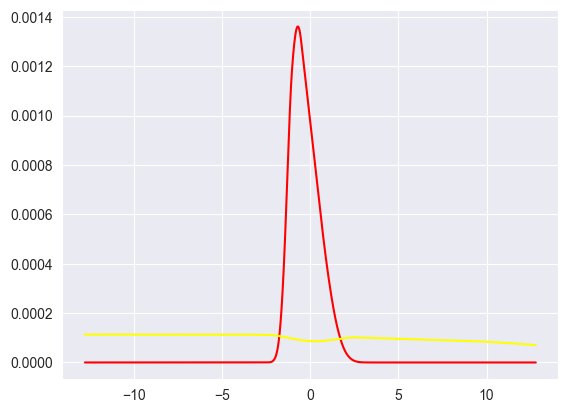

In [17]:
import matplotlib.pyplot as plt
width = 10 * (np.abs(obs_tar) + 1)
x = np.linspace(-width, width, 10000)
plt.plot(x, normalize(np.exp(sel_probs - marginal - np.max(sel_probs - marginal))), color="red")
#plt.plot(x, (marginal), color="blue")
#plt.plot(x, normalize(np.exp(sel_probs)), color="green")
plt.plot(x, normalize(np.exp(sel_probs_full)), color="yellow")
#plt.plot(x, normalize(dist.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.plot(x, normalize(dist_full.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.ylim(-5000, 1000)

In [18]:
sel_probs

array([-7941.1856657 , -7935.28396843, -7929.3853408 , ...,
       -5271.47802617, -5275.65791412, -5279.84016428])

In [19]:
marginal

array([-5388.93308706, -5385.09462674, -5381.25824831, ...,
       -4923.5383174 , -4927.08935912, -4930.64237032])

In [20]:
np.max(np.exp(sel_probs))

np.float64(1.0322895700583892)

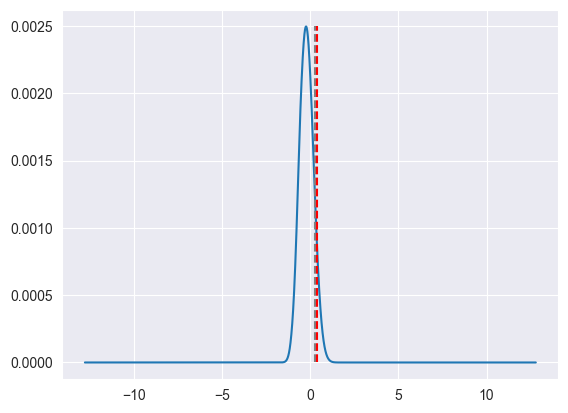

In [21]:
plt.plot(x, dist.pdf(theta=norm_contrast.dot(mu)))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [22]:
dist.pdf(theta=norm_contrast.dot(mu))[x >= obs_tar].sum()

np.float64(0.11405265796532411)

In [168]:
(dist.ccdf(theta=norm_contrast.dot(mu), x=obs_tar))

np.float64(0.9712568481056001)

In [169]:
pval

np.float64(0.45304742336557063)

In [31]:
float("1")

1.0

In [32]:
(x > obs_tar).sum()

np.int64(5000)

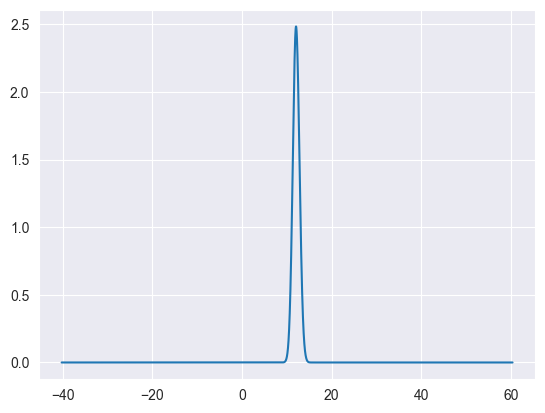

In [33]:
plt.plot(x, np.exp(sel_probs))

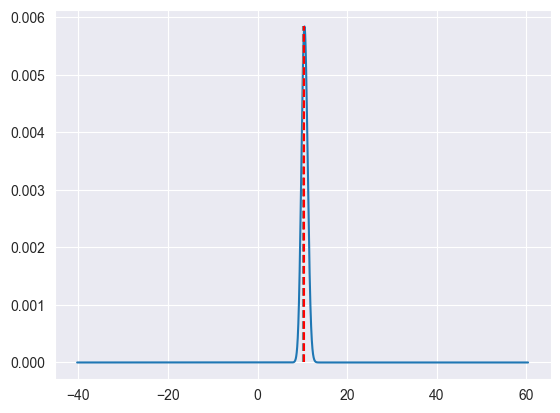

In [34]:
plt.plot(x, dist.pdf(theta=0))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='red')

In [46]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    coverage = []
    naive_coverage = []
    length = []
    naive_length = []
    level=0.1
    for i in range(start, end):
        print(i, "th simulation")
        np.random.seed(i+1000)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=50, max_depth=3,
                                  min_bucket=20, min_proportion=0.)
        reg_tree.fit(X, y, sd = noise_sd * sd_y)
        
        #if not reg_tree.root.left.left:
        #    continue
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs\
            = (reg_tree.condl_split_inference(node=reg_tree.root, ngrid=10000,
                                              ncoarse=100, grid_width=15,
                                              reduced_dim=1, sd=sd_y,
                                              use_cvxpy=True))"""
        
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, marginal \
            = (reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[1],
                                             ngrid=10000,
                                             ncoarse=200,
                                             grid_w_const=5,
                                             reduced_dim=None,
                                             sd=sd_y,
                                             use_cvxpy=False))"""
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
            = (reg_tree.node_inference(node=reg_tree.terminal_nodes[0],
                                             ngrid=10000,
                                             ncoarse=50,
                                             grid_w_const=10,
                                             sd=sd_y,
                                             use_cvxpy=True))
        
        """x = np.linspace(-5 * np.abs(obs_tar), 5 * np.abs(obs_tar), 10000)
        plt.plot(x, normalize(np.exp(sel_probs)), color="yellow")"""
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) -
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) +
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        naive_coverage.append((contrast.dot(mu) >= naive_CI[0] and contrast.dot(mu) <= naive_CI[1]))
        
        selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                   alpha=level))
        selective_CI = np.array(selective_CI)
        selective_CI *= np.linalg.norm(contrast) * sd_y
        coverage.append((contrast.dot(mu) >= selective_CI[0] and contrast.dot(mu) <= selective_CI[1]))
        length.append(selective_CI[1] - selective_CI[0])
        naive_length.append(naive_CI[1] - naive_CI[0])
        if not coverage[-1]:
            print(i)
        
    
    return pivots, naive_pivots, coverage, naive_coverage, length, naive_length

In [47]:
t1 = time()
pivots_50, naive_pivots_50, coverage, naive_coverage, length, naive_length \
    = root_inference_sim(start=0, end=50, n=200,
                         sd_y=2, noise_sd=1, 
                         a=1,b=2)
t2 = time()

0 th simulation


KeyboardInterrupt: 

(array([ 2.,  2.,  2.,  3.,  3.,  3.,  3.,  7., 11., 14.]),
 array([0.01298287, 0.11167672, 0.21037056, 0.3090644 , 0.40775825,
        0.50645209, 0.60514593, 0.70383978, 0.80253362, 0.90122746,
        0.99992131]),
 <BarContainer object of 10 artists>)

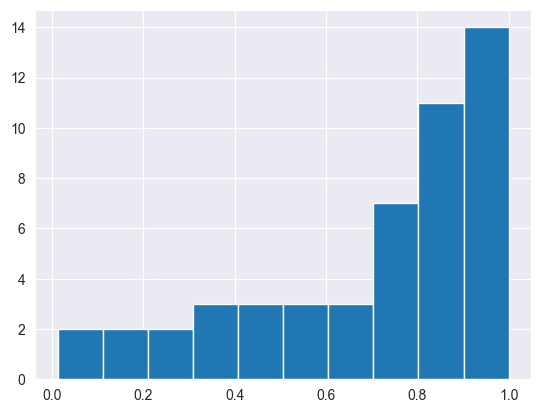

In [35]:
plt.hist(pivots_50, bins=10)

(array([ 1.,  3.,  1.,  3.,  2.,  6.,  6.,  3.,  7., 18.]),
 array([0.00459564, 0.10412722, 0.2036588 , 0.30319038, 0.40272195,
        0.50225353, 0.60178511, 0.70131669, 0.80084827, 0.90037984,
        0.99991142]),
 <BarContainer object of 10 artists>)

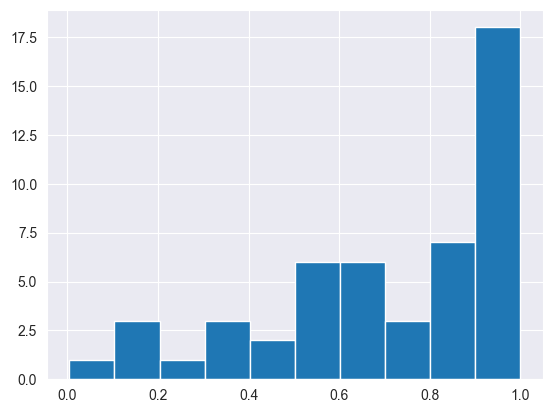

In [36]:
plt.hist(naive_pivots_50, bins=10)

In [38]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post', 
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


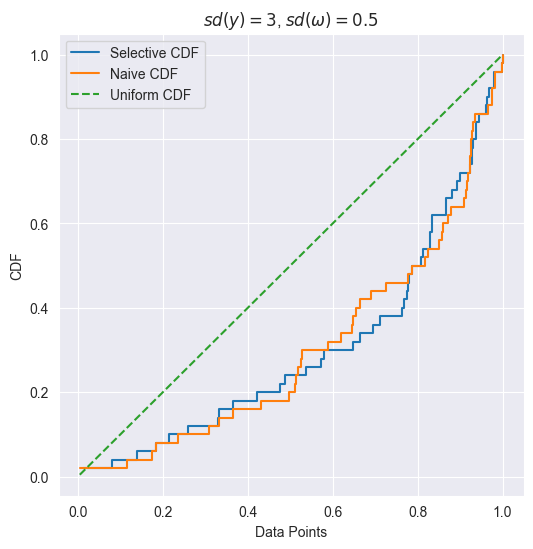

In [39]:
plot_ecdfs([pivots_50, naive_pivots_50], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 0.5$")

In [40]:
np.mean(coverage)

np.float64(0.84)

In [41]:
np.mean(naive_coverage)

np.float64(0.84)

In [42]:
coverage

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_]